In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

In [3]:
df = pd.read_csv('orders.csv',encoding = "ISO-8859-1")

In [4]:
df

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056
3,100328,2014-01-28,Standard,JC-15340,3.928
4,100363,2014-04-08,Standard,JM-15655,21.376
...,...,...,...,...,...
5004,168802,2017-11-03,Standard,JO-15145,18.368
5005,169320,2017-07-23,Second,LH-16900,171.430
5006,169488,2017-09-07,First,AA-10375,56.860
5007,169502,2017-08-28,Standard,MG-17650,113.410


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5009 entries, 0 to 5008
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           5009 non-null   int64  
 1   order_date   5009 non-null   object 
 2   ship_mode    5009 non-null   object 
 3   customer_id  5009 non-null   object 
 4   sales        5009 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 195.8+ KB


In [7]:
# Количественные характеристики числовых переменных
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,5009.0,134608.398083,20229.279765,100006.000,117184.00,134271.00,152226.000,169999.000
sales,5009.0,458.614666,954.730953,0.556,37.63,151.96,512.064,23661.228


In [10]:
# Сконвертируем дату в формат Timestamp
df.order_date = pd.to_datetime(df.order_date)

In [11]:
# Проверим есть ли missing values
df.isna().sum()

id             0
order_date     0
ship_mode      0
customer_id    0
sales          0
dtype: int64

In [12]:
df.dtypes

id                      int64
order_date     datetime64[ns]
ship_mode              object
customer_id            object
sales                 float64
dtype: object

In [64]:
# Рассмотрим Retention между 2014 и 2015 годом
df = df[df.order_date < '2015-01-31']

In [65]:
# Посмотрим на длину датасета по дате заказов
print(f'1st order date purchase in dataset: {min(df.order_date)}; last order date purchase in dataset: {max(df.order_date)}')

1st order date purchase in dataset: 2014-01-03 00:00:00; last order date purchase in dataset: 2014-12-31 00:00:00


In [66]:
# Посмотрим долю от всех клиентов, которые сделали заказ больше одного раза
n_orders = df.groupby(['customer_id'])['id'].nunique()
mult_orders_perc = np.sum(n_orders > 1) / df['customer_id'].nunique()
print(f'{100 * mult_orders_perc:.2f}% of customers ordered more than once.')

44.20% of customers ordered more than once.


In [67]:
l = n_orders.to_frame().reset_index()
print(f'# of customers who ordered at least once: {len(df.customer_id.unique())}, # of customers who ordered only once: {len(l[l.id < 2].id.tolist())}')

# of customers who ordered at least once: 595, # of customers who ordered only once: 332


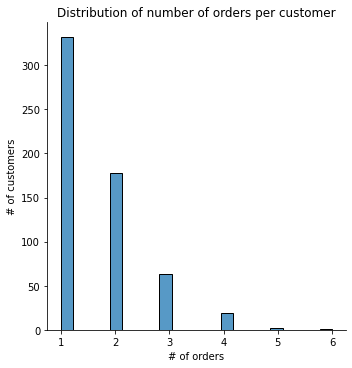

In [74]:
# Посмотрим на распределение количества заказов по клиентам
ax = sns.displot(n_orders, kde=False)
ax.set(title='Distribution of number of orders per customer',
       xlabel='# of orders', 
       ylabel='# of customers');

## Cohort analysis

In [69]:
# Будем относить клиентов к гогортам на основании первой даты покупки
# Поскольку у нас также есть данные по территориальному расположению клиентов (штат и город) и клиентскому сегменту, когортный анализ можно произвести
# в том числе на основании этих переменных

df['order_month'] = df['order_date'].dt.to_period('M')
df['cohort'] = df.groupby('customer_id')['order_date'] \
                 .transform('min') \
                 .dt.to_period('M') 

In [70]:
# Далее мы группируем заказы по когорте и месяцу заказа и считаем колияество уникальных покупателей в каждый месяц
# Добавляем колонку с номером периода, которая отображает количество прошедших периодов с первого месяца покупки

df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('customer_id', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))

In [71]:
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

In [72]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

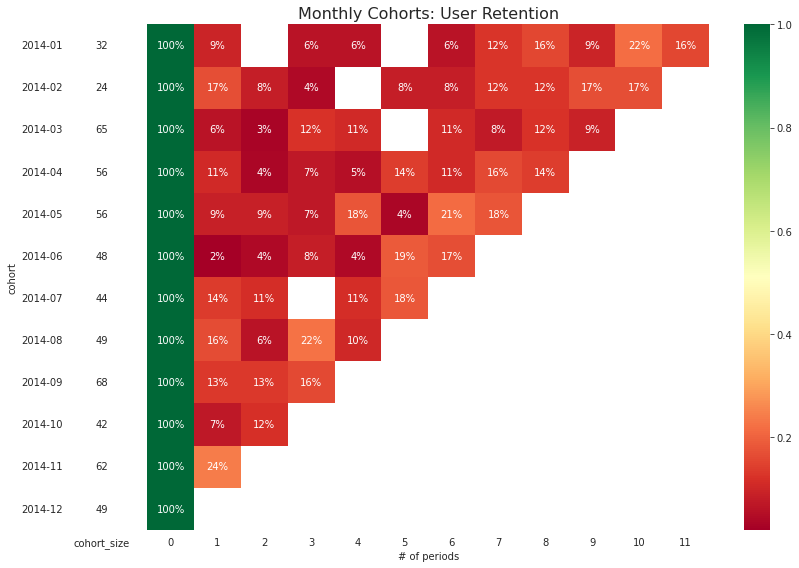

In [73]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()